# Science Spectra Processing

In this notebook, we try to process the Science spectra, i.e., all of the spectra marked with data product type `STAR,DARK,K1` in their fits header. We shall calibrate each of the science file for bias and flat fielding. Later, we shall extract the spectrum and do the wavelength calibration.

Let's first make a list of all of the science files first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from astropy.io import fits
from scipy.optimize import curve_fit as cft
from scipy.optimize import minimize as mz
from matplotlib.widgets import SpanSelector
import ipywidgets as wid
import os
import utils as utl
import order_id as oid

Below, we make a list of all science files in `list_science` variable and visualise one of the science file.

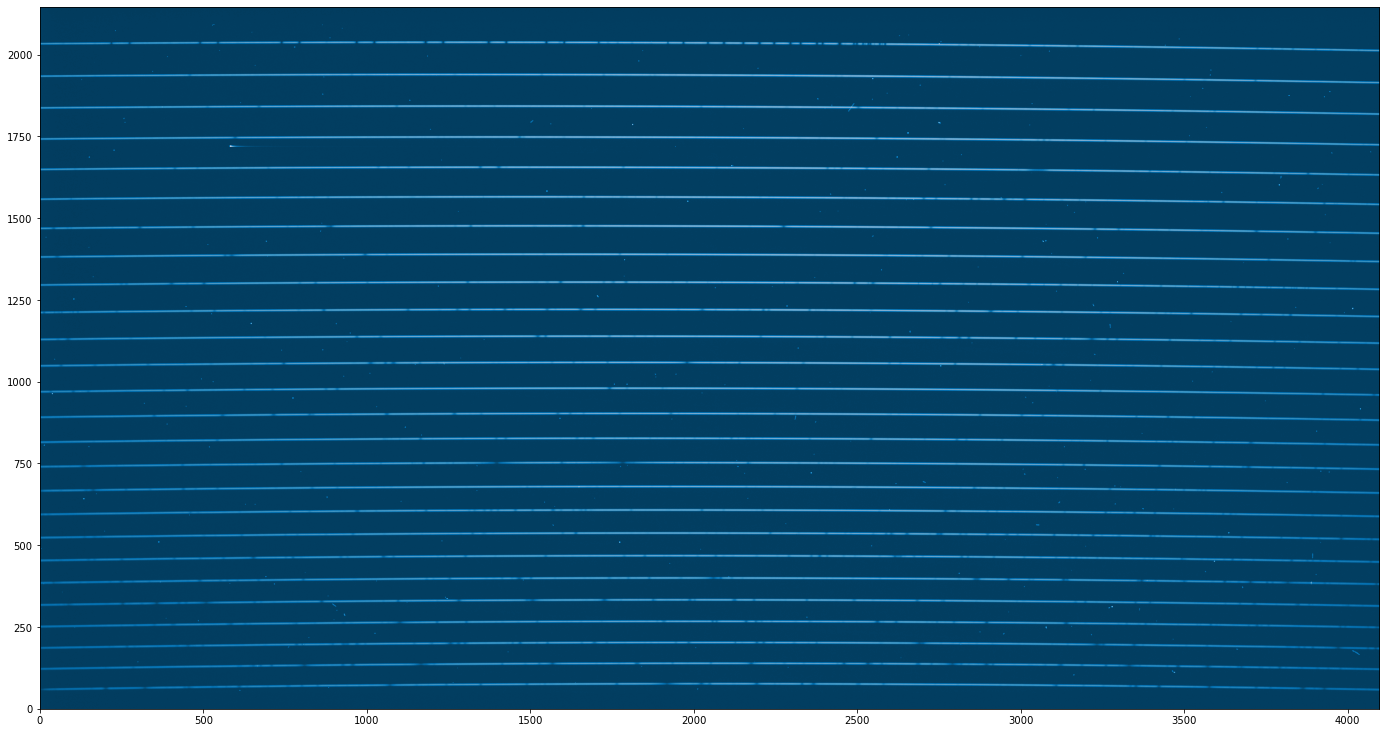

In [2]:
p1 = os.getcwd() + '/Spectro-Module/raw/'
list_all = os.listdir(p1)
list_science = []

for i in range(len(list_all)):
    hdul = fits.open(p1 + list_all[i])
    h11 = hdul[0].header
    if h11['HIERARCH ESO DPR TYPE'] == 'STAR,DARK,K1':
        list_science.append(list_all[i])

list_science.sort(key=utl.natural_keys)

fla1 = fits.open(p1 + list_science[0])
fla2 = fla1[2].data
fla3 = np.transpose(fla2)
plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(fla3, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')

## Bias Subtraction

Now, first, we want to subtract the bias from all of the frame. As usual, we do so by finding the mean value of counts in overscan region. Such region is top 50 raws in the data. We also find the read noise for this data. After doing the bias subtraction, we convert ADU to the electron counts using the conversion factor 1.42 e-/ADU.

Remember that, for now, we are doing the whole procedure for just one of the science file. Later, we will make a loop to do the same for all of the science files.

In [3]:
bias_data = fla3[2098:]
bias_data2 = np.ndarray.flatten(bias_data)
bias_0 = np.mean(bias_data2)
std_0 = np.std(bias_data2)*1.42

# Subtracting the bias
fla4 = fla3 - bias_0
sci_0 = fla4*1.42

## Order Identification and Spectral Extraction

We use the same polynomial as previous to identify the position of the spectrum. We include the errors due to Poisson noise.

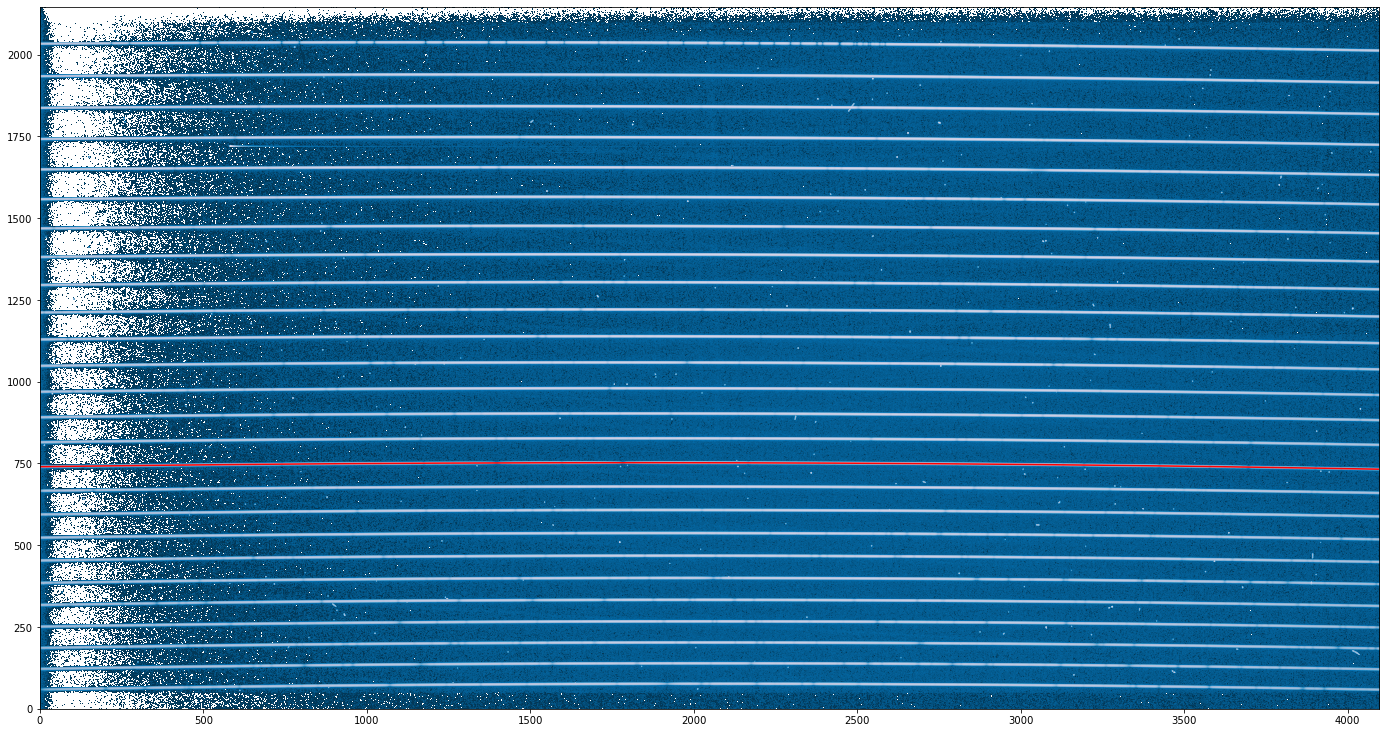

In [4]:
popt1 = np.array([1.49453189e+01, 1.33410596e-02, -3.52806113e-06, -4.42031001e-11])
xdata = np.arange(len(sci_0[0]))
ydata = utl.cubic_104(xdata, *popt1)

plt.figure(figsize=(16*1.5, 9*1.5))
plt.imshow(sci_0, origin='lower', norm=clr.LogNorm(),cmap='PuBu_r')
plt.plot(xdata, ydata, c='red')

So it seems that the polynomial identify the order correctly. We now want to extract the spectral orders with correct error propogation. Below we present the same thing.

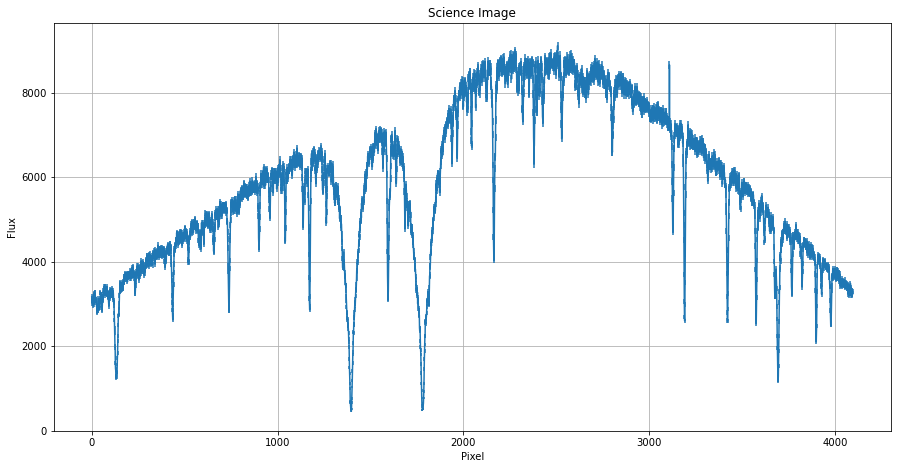

In [5]:
flux_sci = np.array([])
flux_sci_err = np.array([])

for i in range(len(ydata)):
    data = sci_0[int(ydata[i])-7:int(ydata[i]+7), i]
    flx = np.sum(data)
    flux_sci = np.hstack((flux_sci, flx))
    photon_noise = np.sqrt(flx)
    tot_noise = np.sqrt(photon_noise**2 + std_0**2)
    flux_sci_err = np.hstack((flux_sci_err, tot_noise))

plt.figure(figsize=(15,7.5))
plt.errorbar(xdata, flux_sci, yerr=flux_sci_err)
plt.xlabel('Pixel')
plt.ylabel('Flux')
plt.title('Science Image')
plt.grid()

## Correction for flat

We need to correct for the response of the pixels to the light using master flats we computed earlier. We want to divide the so-called master flat to this science spectrum with correct propogation of uncertainty. We do that below.

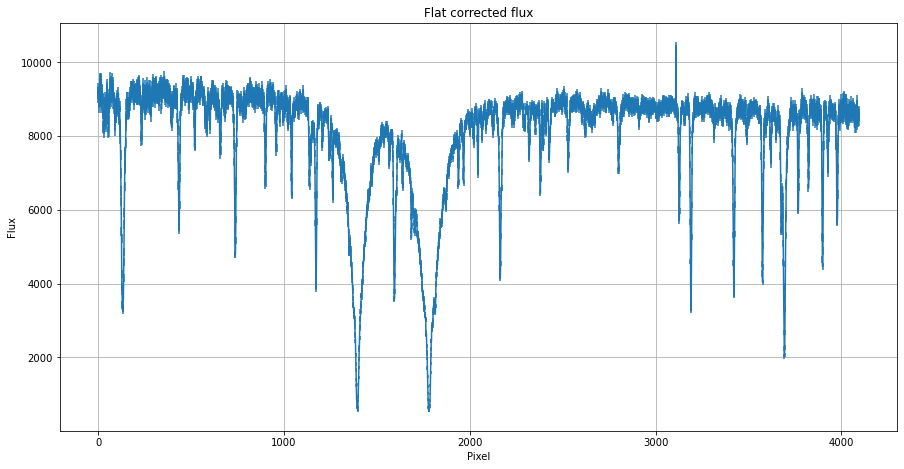

In [6]:
x1, flat, flat_err = np.loadtxt(os.getcwd() + '/Results/flat_alter.dat', usecols=(0,1,2), unpack=True)

flux_sci_fl = flux_sci/flat
flux_sci_fl_err = np.abs(flux_sci_fl)*np.sqrt((flux_sci_err/flux_sci)**2 + (flat_err/flat)**2)

plt.figure(figsize=(15,7.5))
plt.errorbar(xdata, flux_sci_fl, yerr=flux_sci_fl_err)
plt.xlabel('Pixel')
plt.ylabel('Flux')
plt.title('Flat corrected flux')
plt.grid()

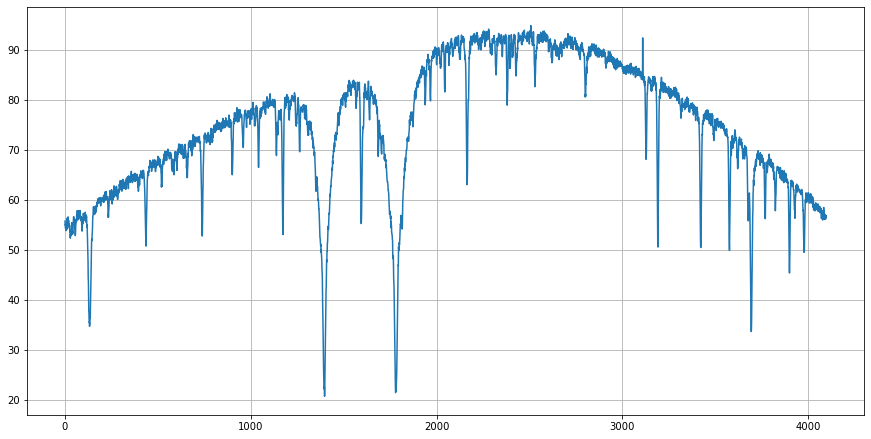

In [7]:
snr = flux_sci_fl/flux_sci_fl_err
plt.figure(figsize=(15,7.5))
plt.plot(xdata, snr)
plt.grid()

It seems okay to me. We now want to define the central position of the line by fitting the Gaussian to it. To do the same, we wrote another pyhon script using the `SpanSelector`. It seems that one cannot use the `SpanSelector` in Jupyter Notebook. So, what we can do is that we export the flat corrected data in data files. Then we use the python script that can read those data files and take the region of the spectrum and fit the gaussian to it. Final product should be the central wavelength in pixel space.

In [8]:
f1 = open(os.getcwd() + '/Results/sci_fl.dat', 'w')

for i in range(len(flux_sci_fl)):
    f1.write(str(xdata[i]) + '\t' + str(flux_sci_fl[i]) + '\t' + str(flux_sci_fl_err[i]) + '\n')

f1.close()

Yeah, so it seemed to work very fine. So now we want to repeat the whole procedure for all other science files.

In [9]:
for j in range(len(list_science)):
    # Reading fits
    fla1_n = fits.open(p1 + list_science[j])
    fla2_n = fla1_n[2].data
    fla3_n = np.transpose(fla2_n)
    # Bias Subtraction
    bias_data = fla3_n[2098:]
    bias_data2 = np.ndarray.flatten(bias_data)
    bias_0 = np.mean(bias_data2)
    std_0 = np.std(bias_data2)*1.42

    # Subtracting the bias
    fla4_n = fla3_n - bias_0
    sci_n = fla4_n*1.42

    # Tracing the order
    xdata_n = np.arange(len(sci_n[0]))
    ydata_n = utl.cubic_104(xdata_n, *popt1)

    # Extracting the flux
    flux_sci_n = np.array([])
    flux_sci_err_n = np.array([])

    for i in range(len(ydata)):
        data = sci_n[int(ydata_n[i])-7:int(ydata_n[i]+7), i]
        flx = np.sum(data)
        flux_sci_n = np.hstack((flux_sci_n, flx))
        photon_noise = np.sqrt(flx)
        tot_noise = np.sqrt(photon_noise**2 + std_0**2)
        flux_sci_err_n = np.hstack((flux_sci_err_n, tot_noise))

    # Correcting for flat
    flux_sci_fl_n = flux_sci_n/flat
    flux_sci_fl_err_n = np.abs(flux_sci_fl_n)*np.sqrt((flux_sci_err_n/flux_sci_n)**2 + (flat_err/flat)**2)

    f11 = open(os.getcwd() + '/Results/' + list_science[j] + '_spectra.dat', 'w')
    for k in range(len(xdata_n)):
        f11.write(str(xdata_n[k]) + '\t' + str(flux_sci_fl_n[k]) + '\t' + str(flux_sci_fl_err_n[k]) + '\n')

    f11.close()

## Position change with time

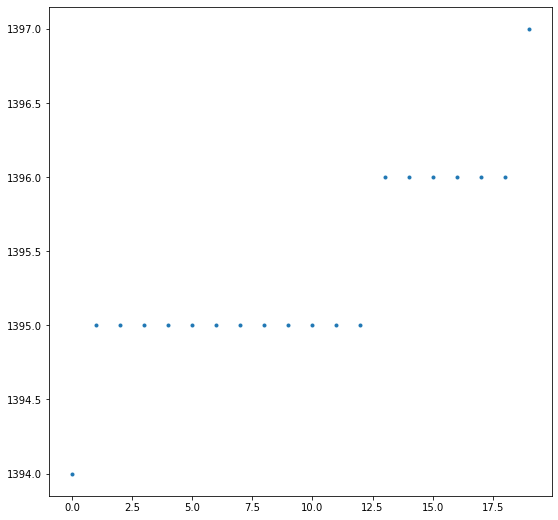

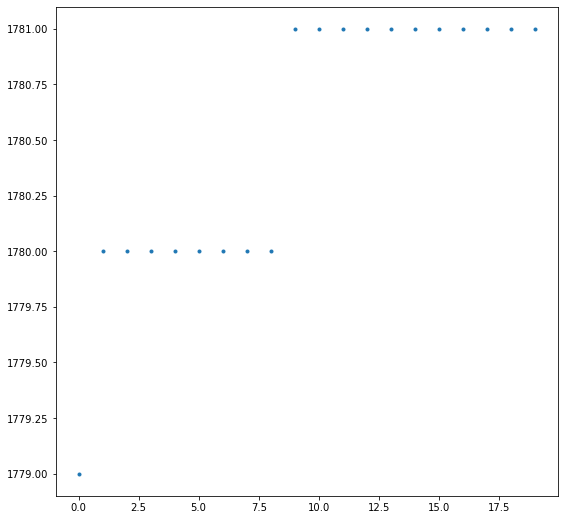

In [10]:
pos1, pos2 = np.loadtxt(os.getcwd() + '/Results/positions.dat', usecols=(0,1), unpack=True)

lin1 = np.sort(pos1)
lin2 = np.sort(pos2)

plt.figure(figsize=(9,9))
plt.errorbar(np.arange(20), lin1, fmt='.')
plt.show()
plt.figure(figsize=(9,9))
plt.errorbar(np.arange(20), lin2, fmt='.')
plt.show()